In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

In [2]:
N = 2
rcpt_types = 3
t = np.arange(0,5000.1, 0.1)
fs = np.arange(0, 101, 1)
fs = fs/1000 #convert from Hz to kHz
c = np.array([0, 25, 50, 100])
cons = len(c)

#[1.7 -1.525; 1.7 -0.5]
Jee = 1.7
Jei = 1.525
Jie = 1.7
Jii = 0.5 
i2e = 0.6

J0 = np.array([[Jee, -Jei], [Jie, -Jii]])
J0

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([[ 1.70000005, -1.52499998],
             [ 1.70000005, -0.5  ]], dtype=float32)

In [3]:
W = J0
print('Det(W) =', '%.3f' % np.linalg.det(W))

#define nonlinearity parameters
kk = 0.04
nn = 2

if rcpt_types > 1:
    g = np.array([1, i2e, 0, 0, 0, 0])
else:
    g = np.array([1, i2e])

tauE = 15
tau_ratio = 1
tauI = tauE/tau_ratio

# tau = np.ones(N)
# tau[:2:] = tauE
# tau[1:2:] = tauI

t_scale = 1
tauNMDA = 100 * t_scale
tauAMPA = 3 * t_scale
tauGABA = 5 * t_scale
nmdaRatio = 0.1 # sets the ratio of NMDA cells to AMPA cell 

NoiseNMDAratio = 0
NoiseTau = 1 * t_scale


totalT = t[-1]
dt = np.mean(np.diff(t))
dt2 = np.sqrt(dt)

Det(W) = 1.742


In [4]:
if rcpt_types > 1:
    tauS = np.array([tauAMPA, tauNMDA, tauGABA])
    tauSvec = np.kron(tauS, np.ones(N))
    
    Wtot = np.array([[(1-nmdaRatio)*Jee, 0, 0, 0, 0, 0], [(1-nmdaRatio)* Jie, 0, 0, 0, 0, 0], [0, 0, nmdaRatio * Jee, 0, 0, 0], [0, 0, nmdaRatio * Jie, 0, 0, 0], [0, 0, 0, 0, 0, -Jei], [0, 0, 0, 0, 0, -Jii]])
    
else:
    tauSvec = tau
    Wrcpt = W
    Wtot = W
    

In [46]:
v1 = np.zeros([N*rcpt_types, cons])
r_starcons = np.zeros([N, cons])

vv_t = np.zeros([len(t), N*rcpt_types, cons])
# v1 = np.zeros(N*rcpt_types)
# r_t = np.zeros([len(t), N, cons])
# tt_c = np.zeros([len(t), cons])

In [16]:
def rect_powerLaw(vv, kk, nn):
    fv = kk*np.maximum(np.array([np.sum(vv[::2,:], axis=0), np.sum(vv[1::2,:],axis=0)]), np.zeros([N, cons]))**nn
    return fv

def dvdt(vv):
    delta_v = np.reshape(dt/tauSvec, [6,1]) * (-vv + Wtot @ np.kron(np.ones([rcpt_types,1]), rect_powerLaw(vv, kk ,nn)) + I_total)
    return delta_v


In [17]:
I_total = np.kron( g.reshape(N*rcpt_types,1),  c.reshape(1,cons))
# I_total = np.kron(c, g)
# I_total = np.transpose(np.reshape(I_total, [4, 6]))
I_total

DeviceArray([[  0.      ,  25.      ,  50.      , 100.      ],
             [  0.      ,  15.00000095,  30.00000191,  60.00000381],
             [  0.      ,   0.      ,   0.      ,   0.      ],
             [  0.      ,   0.      ,   0.      ,   0.      ],
             [  0.      ,   0.      ,   0.      ,   0.      ],
             [  0.      ,   0.      ,   0.      ,   0.      ]],
            dtype=float32)

In [47]:
Conv = True
indt = 0
xtol = 1e-3
xmin = 1
vv_t =[]

for tt in t:

    dv = dvdt(v1)
    v1 = dv + v1
    vv_t.append(v1)
    indt += 1
    
    if np.abs( dv /np.maximum(xmin, np.abs(v1)) ).max() < xtol:
            # print('\n converged to fixed point at t=%g,      as max(abs(dx./max(xvec,%g))) < %g \n' % (n*dt,xmin,xtol))
            # CONVG = 1
            print(tt)
            break
    
    if tt >= totalT - 1000*dt:
        itr = np.max(np.abs(dv))
        
        if itr > 0.01:
            Conv = False

60.1


602
(601,)
60.1


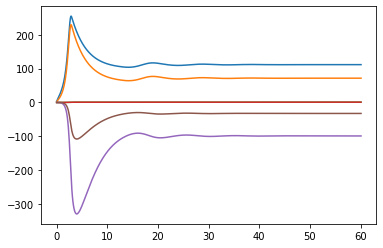

In [48]:
print(len(vv_t))
print(np.arange(0,tt, dt).shape)
print(tt)

# import matplotlib.pyplot as plt

plt.plot(np.arange(0,tt+dt, dt), np.array(vv_t)[:,:,4])

In [14]:
r_starcons = rect_powerLaw(v1, kk, nn)
rs = nn*kk**(1/nn)*r_starcons**(1-1/nn)
v1

DeviceArray([[  0.       ,  36.47018433,  63.64902878, 111.50494385],
             [  0.       ,  26.4701767,  43.64903259,  71.50494385],
             [  0.       ,   1.27440214,   1.51650786,   1.27829814],
             [  0.       ,   1.27440214,   1.51650786,   1.27829814],
             [  0.       , -24.05441475, -50.23153305, -99.07230377],
             [  0.       ,  -7.88669729, -16.46936035, -32.48272324]],
            dtype=float32)

In [30]:
Gf = -1j * 2 * np.pi * ff * np.diag(np.kron(tauS, np.ones(N))) - J
Gf.shape

(6, 6)

In [12]:
Phi = lambda rr: np.diag(rr)
eE = np.array([[1], [0]])
eE = np.kron(np.ones([rcpt_types,1]), eE)
J = np.array([[Wtot @ np.kron(np.ones([rcpt_types, rcpt_types]), Phi(rs[:,cc])) -np.eye(N*rcpt_types)] for cc in range(cons)])
Gf = np.array([-1j * 2 * np.pi * ff * np.diag(np.kron(tauS, np.ones(N))) - J[cc,1] for cc in range(cons) for ff in fs])

cuE = np.array([eE for cc in range(cons) for ff in fs])
fscons = np.kron(np.ones([1, cons]), fs)

In [13]:
# iGf = np.linalg.inv(Gf)

# x = np.einsum("ijk, ikm-> ijm", iGf, cuE)
# x = np.matmul(iGf, cuE)
x = np.linalg.solve(Gf, cuE)

y = (1-NoiseNMDAratio) * x[:, :N] + NoiseNMDAratio * x[:, N:(N+N)]
y_conj = np.transpose(np.conj(y), [0, 2, 1])

# spect = np.einsum('ijk, imk -> ijm', y_conj, y)
tapercons = 2 * NoiseTau/np.abs(-1j * 2 * np.pi * fscons * NoiseTau + 1)**2

spect = np.squeeze(np.matmul(y_conj, y)) * np.squeeze(tapercons)

spect = np.reshape(spect*2/1000, [len(fs), cons], order='F')
spect = spect/np.mean(spect)


In [283]:
x[:, N:2*N].shape

(404, 2, 1)

In [14]:
import matplotlib.pyplot as plt

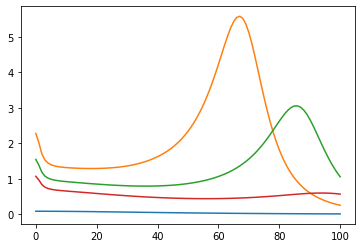

In [15]:
plt.plot(fs*1000, np.real(spect))

In [257]:
tapercons.shape

(1, 404)

In [206]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B = np.ones_like(A)
C = np.einsum("ij, jl -> il", A, B)
C

DeviceArray([[ 6,  6,  6],
             [15, 15, 15],
             [24, 24, 24]], dtype=int32)

In [237]:
a = np.array([[[1., 2.], [3., 4.]], [[1, 3], [3, 5]]])
inv_a = np.linalg.inv(a)
inv_a

DeviceArray([[[-2.00000024,  1.00000012],
              [ 1.50000012, -0.50000006]],

             [[-1.25000012,  0.75000006],
              [ 0.75000006, -0.25000003]]], dtype=float32)

In [297]:
def sum_logistic(x):
    return np.sum(1.0 / (1.0 + np.exp(-x)))


In [302]:
x_small = np.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

sum_logistic(x_small)

[0.25       0.19661197 0.10499357]


DeviceArray(2.1118555, dtype=float32)

In [303]:
def first_finite_differences(f, x):
  eps = 1e-3
  return np.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in np.eye(len(x))])


print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1964569  0.10502338]


In [271]:
np.linalg.inv(Gf[102])

DeviceArray([[ 2.02596545+0.00523263j, -1.38562214-0.00588392j,
               0.75048965+0.43859053j, -1.00262594-0.60973394j,
               1.02608693-0.00072046j, -1.38500178-0.02327667j],
             [ 1.02632082-0.01361023j, -0.38597748+0.01295893j,
               0.75048971+0.43859062j, -1.00262606-0.609734j  ,
               1.02608693-0.00072046j, -1.3850019 -0.02327668j],
             [ 0.08338774+0.04873229j, -0.11140289-0.06774823j,
               0.75615603+0.52226734j, -0.05121355-0.09782675j,
               0.08274308+0.04975992j, -0.11050843-0.06912006j],
             [ 0.08338774+0.04873229j, -0.11140289-0.06774823j,
               0.03919928+0.0717901j ,  0.66574323+0.35265046j,
               0.08274307+0.04975992j, -0.11050843-0.06912005j],
             [-1.49702525-0.07363215j,  0.67005605+0.08570754j,
              -1.05383956-0.70756078j,  0.4486399 +0.35496598j,
              -0.49649641-0.06101178j,  0.66871572+0.0940856j ],
             [-0.49082792-0.0241416

In [270]:
Gf[102]

DeviceArray([[-0.67567706-0.01884956j,  0.        +0.j        ,
              -1.67567706+0.j        ,  0.        +0.j        ,
              -1.67567706+0.j        ,  0.        +0.j        ],
             [-1.67567706+0.j        ,  1.        -0.01884956j,
              -1.67567706+0.j        ,  0.        +0.j        ,
              -1.67567706+0.j        ,  0.        +0.j        ],
             [-0.18618634+0.j        ,  0.        +0.j        ,
               0.81381369-0.62831855j,  0.        +0.j        ,
              -0.18618634+0.j        ,  0.        +0.j        ],
             [-0.18618634+0.j        ,  0.        +0.j        ,
              -0.18618634+0.j        ,  1.        -0.62831855j,
              -0.18618634+0.j        ,  0.        +0.j        ],
             [ 0.        +0.j        ,  2.42266154+0.j        ,
               0.        +0.j        ,  2.42266154+0.j        ,
               1.        -0.03141593j,  2.42266154+0.j        ],
             [ 0.        +0.j      

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

from rates_2D import loss 

In [2]:
Jee = 1.8
Jei = 1.525
Jie = 1.7
Jii = 0.5 
i2e = 0.6

derivative_loss = grad(loss, argnums=(0,1,2,3,4))

dJee, dJei, dJie, dJii, di2e = derivative_loss(Jee, Jei, Jie, Jii, i2e)
print([dJee, dJei, dJie, dJii, di2e])

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


91.5


/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


[DeviceArray(0., dtype=float32), DeviceArray(-0., dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(-0., dtype=float32), DeviceArray(0., dtype=float32)]


In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

from rates_2D import PS_ratesSS
import matplotlib.pyplot as plt

In [22]:
Jee = 1.7
Jei = 1.525
Jie = 1.7
Jii = 0.5 
i2e = 0.6
fs = np.arange(0,101,1)

spect, vv = PS_ratesSS(Jee, Jei, Jie, Jii, i2e)


/Users/cholt/miniconda3/envs/juC/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


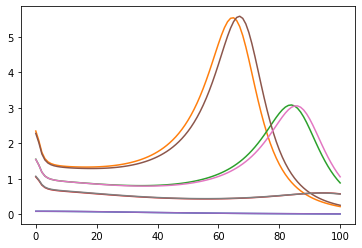

In [23]:
ideal_spect = np.array([[0.08905868-3.83732629e-11j, 2.28040481-9.82572024e-10j,
              1.5483824 -6.67161049e-10j, 1.07329059-4.62455296e-10j],
             [0.08902354-8.64453092e-11j, 2.02083063+5.47442802e-09j,
              1.38844359-9.76937753e-10j, 0.97001064+1.92841498e-09j],
             [0.08891826+1.17891100e-10j, 1.70275915+2.10067919e-09j,
              1.18842018-6.23987806e-10j, 0.83983177-2.72357603e-09j],
             [0.08874326+1.00949131e-10j, 1.53278792+6.75992506e-09j,
              1.07917356-8.96971997e-10j, 0.76802617-1.22968968e-09j],
             [0.08849936-5.76124912e-11j, 1.44636357-6.67382427e-10j,
              1.02231419-1.66228342e-09j, 0.73014909+2.03485839e-10j],
             [0.08818755+6.57584681e-11j, 1.39852989-1.55678659e-09j,
              0.98973948-5.95518479e-09j, 0.70797586-1.29886624e-09j],
             [0.08780912-3.61084912e-10j, 1.36945009-7.49414220e-09j,
              0.96885109-1.12334364e-09j, 0.69329047+2.79549583e-09j],
             [0.08736569-3.99056344e-10j, 1.35025442-3.09665116e-09j,
              0.95397484-5.01610808e-10j, 0.68238384-2.91438274e-09j],
             [0.08685909+4.38105940e-11j, 1.33668041+3.08961773e-10j,
              0.9423728 +3.63985864e-09j, 0.6734674 +8.67393726e-11j],
             [0.08629135+3.95463627e-11j, 1.32652938-4.56809257e-09j,
              0.93263322-5.69120395e-09j, 0.66561967+4.47429738e-09j],
             [0.08566476+5.24959520e-10j, 1.31860495-5.17547116e-09j,
              0.92398798+5.46343415e-10j, 0.65834254-5.29281197e-09j],
             [0.08498174-4.31081802e-11j, 1.31222582+2.82477353e-09j,
              0.91600198-5.44267653e-09j, 0.65135622-2.33199815e-09j],
             [0.08424494-2.46322351e-10j, 1.30700064+1.88406096e-10j,
              0.90842527+1.36433742e-09j, 0.64450186-4.17848511e-09j],
             [0.08345712+3.77096743e-10j, 1.30270171-7.10063652e-09j,
              0.90111297-3.12332338e-09j, 0.6376906 -1.56055235e-09j],
             [0.08262113+2.69063938e-10j, 1.29920125+8.77288797e-10j,
              0.89398593-2.14694262e-09j, 0.63087493+2.54389954e-09j],
             [0.08173997-5.61180435e-10j, 1.29643536+4.48796733e-09j,
              0.88700181-1.48796930e-09j, 0.62403286+2.71376144e-09j],
             [0.08081668-7.64792896e-10j, 1.29438162-4.83762308e-10j,
              0.88014513-1.04475251e-09j, 0.61715943+4.05003320e-09j],
             [0.07985433-6.37725095e-10j, 1.29304445-3.14422044e-09j,
              0.87341589+1.60661373e-10j, 0.61025846+6.12752915e-09j],
             [0.07885607-1.34402234e-09j, 1.29244757-1.20850032e-08j,
              0.86682367-1.40510228e-10j, 0.60334027+3.14955861e-09j],
             [0.07782501+6.98945235e-10j, 1.29262793+1.45300760e-09j,
              0.8603853 +4.06697831e-09j, 0.59641939+2.91377839e-10j],
             [0.07676425+1.86522728e-10j, 1.29363334+2.61409383e-09j,
              0.85412109-3.45770235e-09j, 0.58951175+4.11911261e-09j],
             [0.0756769 +5.22582366e-10j, 1.29551876-7.61760433e-09j,
              0.84805423+1.75084780e-09j, 0.58263463-2.93280267e-09j],
             [0.07456594-6.88869128e-10j, 1.29834592+1.53419666e-09j,
              0.84220779+1.09016884e-08j, 0.57580483+1.72690773e-09j],
             [0.07343435-2.42418967e-11j, 1.30218327-1.51312435e-11j,
              0.83660644-4.39126513e-09j, 0.56903934+2.64433053e-09j],
             [0.072285  -5.60403224e-10j, 1.30710292-5.87827609e-09j,
              0.83127493+2.59199218e-09j, 0.56235415-4.42582015e-09j],
             [0.07112066-6.42937037e-10j, 1.31318438-1.01151496e-08j,
              0.82623744-8.34738589e-09j, 0.55576396-6.29031105e-10j],
             [0.06994408-8.11978762e-10j, 1.32051361+3.30365801e-09j,
              0.82151717-1.06120801e-09j, 0.5492835 -1.40217227e-09j],
             [0.06875779-1.86082011e-10j, 1.32918108+6.96937619e-10j,
              0.81713814-1.08406297e-08j, 0.54292583+4.32100533e-09j],
             [0.06756427-4.81070295e-10j, 1.3392868 -2.78067547e-09j,
              0.81312281-1.14546594e-08j, 0.53670263-2.48684384e-09j],
             [0.06636591+4.26350566e-10j, 1.3509382 -1.16909744e-08j,
              0.8094945 -2.64267341e-09j, 0.53062516+3.04592973e-09j],
             [0.06516486+9.87095738e-10j, 1.36425173+7.24529992e-09j,
              0.80627495+4.82119500e-09j, 0.52470326+1.51169011e-09j],
             [0.06396323-4.02903544e-10j, 1.37935615-4.74530371e-09j,
              0.80348641+4.71325245e-09j, 0.51894605+4.24551505e-09j],
             [0.06276301+1.24310262e-09j, 1.39639163-2.32006148e-09j,
              0.80115193+5.91368110e-09j, 0.51336116+2.19356111e-09j],
             [0.06156605+4.47988070e-11j, 1.41551316-2.06245750e-11j,
              0.79929399+2.27759234e-09j, 0.50795686-7.28675398e-10j],
             [0.06037404-1.26991240e-09j, 1.43689144+2.63744560e-09j,
              0.7979359 -8.57866134e-09j, 0.50273919-4.30309566e-09j],
             [0.05918859+2.06196213e-10j, 1.46071374-1.14775505e-08j,
              0.7971012 +3.30789396e-10j, 0.49771431-2.64368055e-10j],
             [0.05801112+1.19814292e-09j, 1.48719442+1.20330024e-09j,
              0.79681486+5.42851364e-09j, 0.4928875 +2.94638158e-09j],
             [0.05684301-6.18538942e-10j, 1.5165658 +3.22878835e-09j,
              0.7971034 -1.03589071e-09j, 0.48826402+2.55144106e-09j],
             [0.05568548+1.06438502e-09j, 1.54908967-1.96562286e-08j,
              0.79799372+8.69620553e-09j, 0.48384753+5.89988369e-09j],
             [0.05453961-4.30880276e-10j, 1.58506048-2.02362949e-09j,
              0.79951447+1.16759304e-08j, 0.47964284+1.69165071e-09j],
             [0.05340647-1.10370557e-09j, 1.62480927+7.68919328e-09j,
              0.80169725+2.52928078e-09j, 0.47565347+1.42977463e-10j],
             [0.05228692-1.70523079e-12j, 1.66870403+3.14337267e-09j,
              0.80457473+7.53711482e-10j, 0.47188276+1.11751497e-09j],
             [0.05118177+1.20540988e-09j, 1.71716237-1.71100190e-10j,
              0.80818379-4.72355444e-09j, 0.46833414-2.38502418e-09j],
             [0.05009175-1.49078638e-10j, 1.77065194-6.23637630e-09j,
              0.81256199+1.14712767e-10j, 0.46501055-6.74621914e-10j],
             [0.04901748+5.46089618e-10j, 1.82970214-2.59307020e-10j,
              0.81775194+2.73242007e-09j, 0.46191481-2.97074432e-09j],
             [0.04795947+3.21147386e-10j, 1.89490867-4.04288070e-09j,
              0.82380092+7.52336415e-09j, 0.45905042-2.29368857e-09j],
             [0.04691822+3.74071524e-10j, 1.96694088-1.09020437e-08j,
              0.83075702-6.02471739e-10j, 0.45641938+3.72883902e-09j],
             [0.0458941 +1.98729505e-10j, 2.04654908-1.20539037e-08j,
              0.83867735-2.47948928e-09j, 0.4540253 -2.85621371e-09j],
             [0.04488745-8.75667150e-10j, 2.13457537-6.98623692e-09j,
              0.84762156-4.27264624e-09j, 0.45187029+1.47575130e-09j],
             [0.04389853-6.45250464e-10j, 2.2319572 -7.48003082e-09j,
              0.85765606+5.20938004e-09j, 0.44995773-1.39483725e-09j],
             [0.04292753-5.15501419e-10j, 2.33972454-1.26098065e-09j,
              0.86885506-1.85411728e-10j, 0.44829071+2.61997468e-09j],
             [0.04197459+2.44679641e-11j, 2.45900726+3.06269818e-08j,
              0.88129818+6.74345335e-09j, 0.44687194+3.95308142e-09j],
             [0.04103981-8.50245097e-10j, 2.5910182 +1.58950169e-08j,
              0.89507604-2.73929368e-09j, 0.44570491-4.13689261e-09j],
             [0.04012324-5.65485983e-12j, 2.73701906+3.41761996e-08j,
              0.91028708-5.66398350e-09j, 0.4447929 -5.24458610e-09j],
             [0.0392249 +3.81940091e-10j, 2.89828038+3.21430633e-08j,
              0.92704231-7.30520711e-09j, 0.44413936+2.18945240e-09j],
             [0.03834476-2.71569683e-10j, 3.07599783+1.50710129e-08j,
              0.94546139+7.10236936e-09j, 0.4437483 -5.19020116e-09j],
             [0.03748276-3.01650371e-10j, 3.27113771-2.47122891e-08j,
              0.96568012-8.99942254e-09j, 0.44362301+3.77380616e-09j],
             [0.03663877-1.96456462e-10j, 3.48425245+8.79918449e-09j,
              0.98784888+8.69053096e-09j, 0.4437674 +1.02656883e-09j],
             [0.03581271+2.11515083e-10j, 3.71517134-4.13965715e-08j,
              1.01213276-1.08077796e-08j, 0.44418618-1.50534119e-09j],
             [0.03500441-3.83715282e-10j, 3.96257615+2.55911079e-08j,
              1.03871655-1.64367684e-08j, 0.44488347-2.70752198e-09j],
             [0.03421371+1.41770179e-10j, 4.22345781-4.21432560e-08j,
              1.06780577+1.90666345e-08j, 0.44586378-3.65885833e-09j],
             [0.03344039+2.04201059e-10j, 4.49246788-3.64574682e-08j,
              1.09962618-1.12460330e-09j, 0.44713101-2.41298692e-09j],
             [0.03268429-5.71276249e-10j, 4.76121855+5.78950718e-08j,
              1.13442969+1.25737998e-08j, 0.44869053+1.60292557e-09j],
             [0.03194514+3.93990396e-11j, 5.01776028+2.44043825e-08j,
              1.17249453-5.37828537e-09j, 0.45054603-3.44197532e-10j],
             [0.03122272+9.82057560e-11j, 5.24649143+3.28153682e-08j,
              1.21412623+4.65580730e-09j, 0.45270267-6.89763385e-11j],
             [0.03051676+2.00426994e-10j, 5.42895269+9.30937283e-09j,
              1.25965929-9.07090070e-10j, 0.45516413+1.63532687e-09j],
             [0.02982704+5.32779168e-11j, 5.54581738+4.96141013e-08j,
              1.30945766-1.99780903e-08j, 0.4579345 +1.01300026e-08j],
             [0.02915327-3.52413682e-10j, 5.57997942-1.38949003e-08j,
              1.3639164 +1.22858550e-08j, 0.46101785+2.78318835e-09j],
             [0.02849516-5.47857371e-10j, 5.52035809-8.84825369e-09j,
              1.42345345-2.75703504e-09j, 0.46441635-4.24076996e-09j],
             [0.02785245+2.90496238e-10j, 5.36495829-8.72469652e-09j,
              1.48850846+4.18282031e-09j, 0.46813276+1.64581249e-09j],
             [0.02722484+4.05190409e-10j, 5.1220274 -5.59738089e-10j,
              1.55952835+1.03039346e-08j, 0.47216794+2.65280659e-10j],
             [0.02661205-5.07165976e-10j, 4.80860138-4.63760443e-08j,
              1.63695049+1.00050102e-08j, 0.47652191-8.49344595e-09j],
             [0.02601379+1.74175160e-10j, 4.44698143+2.35449047e-08j,
              1.72117734-1.02188373e-08j, 0.48119307+6.94993751e-09j],
             [0.02542976-8.43525250e-11j, 4.06044292-8.09057321e-10j,
              1.81253564+1.60190350e-08j, 0.48617741-4.79888407e-10j],
             [0.02485966+2.11428323e-11j, 3.66971755+1.05455991e-08j,
              1.91120887-1.51596069e-08j, 0.49146837+4.64330885e-09j],
             [0.02430321+4.83116602e-10j, 3.2909162 -5.76637547e-08j,
              2.01717591-1.47805386e-08j, 0.49705791-1.01530802e-08j],
             [0.02376013-7.78858575e-11j, 2.93501019-2.36088518e-08j,
              2.13009286+9.68959468e-10j, 0.50293279-5.12235705e-11j],
             [0.02323009-4.00498024e-10j, 2.60831022-2.70396683e-08j,
              2.24915075-1.96835650e-08j, 0.50907612-3.00297387e-09j],
             [0.02271283+1.92761623e-11j, 2.31347823+4.00069951e-08j,
              2.37291813+1.25125474e-08j, 0.51546645-3.26937122e-09j],
             [0.02220805+2.60752780e-10j, 2.05062628+2.56183945e-08j,
              2.49915409+3.55206282e-08j, 0.52207613-4.95426589e-09j],
             [0.02171548-3.44090034e-10j, 1.81824231+1.10060485e-08j,
              2.62462711-1.04556106e-08j, 0.52887154+5.16136645e-09j],
             [0.02123483+4.38490549e-10j, 1.61392951+1.44518451e-08j,
              2.74497461+1.66030034e-08j, 0.53581053-8.34165803e-09j],
             [0.02076581+3.10530157e-10j, 1.43489182+1.13995746e-08j,
              2.85470915+1.40056216e-08j, 0.5428437 -2.55647103e-09j],
             [0.02030818+2.67708328e-10j, 1.27826416-5.80195669e-09j,
              2.94737911+8.01153721e-09j, 0.54991227-8.77568329e-09j],
             [0.01986163-4.48514087e-10j, 1.14130306-4.06656309e-09j,
              3.0160327 +7.64618058e-09j, 0.55694562-4.06128509e-09j],
             [0.01942591+2.58207275e-11j, 1.02148259+9.73272218e-09j,
              3.05399108-1.02386934e-08j, 0.56386405+6.24499519e-09j],
             [0.01900078+1.43510995e-10j, 0.916538  +1.53981472e-09j,
              3.05582333+1.49404700e-09j, 0.57057488-9.94448701e-09j],
             [0.01858595+1.87237226e-10j, 0.82447571+1.03648379e-08j,
              3.01834035-6.67959599e-09j, 0.57697356-2.28532415e-09j],
             [0.01818119+3.76800639e-11j, 0.74355286-1.29503741e-09j,
              2.94137025+6.98303104e-09j, 0.58294553+2.89794039e-11j],
             [0.01778624-1.25802688e-10j, 0.67226696-1.59992253e-09j,
              2.82797265+1.32529463e-08j, 0.58836257-7.48901741e-09j],
             [0.01740088-1.92181659e-10j, 0.60932344-6.68985534e-09j,
              2.68402147-6.21356744e-09j, 0.59308803+2.20733432e-09j],
             [0.01702484-7.41711415e-11j, 0.55360943-1.83948037e-10j,
              2.51729035-1.61100271e-08j, 0.59697706+2.03090678e-09j],
             [0.0166579 -2.47339982e-10j, 0.50417203-6.11522000e-10j,
              2.33627629+1.95800052e-08j, 0.59988022+1.34971490e-09j],
             [0.01629985-4.57373167e-11j, 0.4601956 +9.68523928e-10j,
              2.14907932-1.43388705e-08j, 0.60164672+3.28541172e-09j],
             [0.01595044+1.09327866e-10j, 0.42097896-7.02269465e-10j,
              1.96264148-1.38398448e-09j, 0.60213035-4.26479474e-09j],
             [0.01560946+7.85286905e-11j, 0.38592196-4.34896918e-09j,
              1.78234148-5.89064664e-09j, 0.601192  +9.21060561e-10j],
             [0.01527671-9.80730427e-11j, 0.35450777+2.60570010e-09j,
              1.61192179-1.07356630e-08j, 0.5987103 -4.21611940e-10j],
             [0.01495197+1.57837743e-10j, 0.32629171+1.36987888e-09j,
              1.45366836-2.62485109e-08j, 0.59458345+2.86139917e-10j],
             [0.01463504+8.71452823e-12j, 0.30088997-2.74232415e-09j,
              1.30868495-2.05886219e-09j, 0.58873898-1.99613659e-09j],
             [0.01432572-9.07193556e-11j, 0.27797109+1.28933730e-09j,
              1.17719555+1.03646993e-08j, 0.58113426-3.11666914e-10j],
             [0.01402381-1.63865060e-10j, 0.2572476 -2.50080801e-09j,
              1.05882764+1.00782414e-08j, 0.5717662 +2.03064052e-10j]])
ideal_spect =ideal_spect/np.mean(ideal_spect)



plt.plot(fs, spect, fs, ideal_spect)

In [24]:
def loss(Jee, Jei, Jie, Jii, i2e):

    spect, r_starcons = PS_ratesSS(Jee, Jei, Jie, Jii, i2e)
    spect = np.real(spect)

    ideal_spect = np.real(np.array([[0.08905868-3.83732629e-11j, 2.28040481-9.82572024e-10j,
              1.5483824 -6.67161049e-10j, 1.07329059-4.62455296e-10j],
             [0.08902354-8.64453092e-11j, 2.02083063+5.47442802e-09j,
              1.38844359-9.76937753e-10j, 0.97001064+1.92841498e-09j],
             [0.08891826+1.17891100e-10j, 1.70275915+2.10067919e-09j,
              1.18842018-6.23987806e-10j, 0.83983177-2.72357603e-09j],
             [0.08874326+1.00949131e-10j, 1.53278792+6.75992506e-09j,
              1.07917356-8.96971997e-10j, 0.76802617-1.22968968e-09j],
             [0.08849936-5.76124912e-11j, 1.44636357-6.67382427e-10j,
              1.02231419-1.66228342e-09j, 0.73014909+2.03485839e-10j],
             [0.08818755+6.57584681e-11j, 1.39852989-1.55678659e-09j,
              0.98973948-5.95518479e-09j, 0.70797586-1.29886624e-09j],
             [0.08780912-3.61084912e-10j, 1.36945009-7.49414220e-09j,
              0.96885109-1.12334364e-09j, 0.69329047+2.79549583e-09j],
             [0.08736569-3.99056344e-10j, 1.35025442-3.09665116e-09j,
              0.95397484-5.01610808e-10j, 0.68238384-2.91438274e-09j],
             [0.08685909+4.38105940e-11j, 1.33668041+3.08961773e-10j,
              0.9423728 +3.63985864e-09j, 0.6734674 +8.67393726e-11j],
             [0.08629135+3.95463627e-11j, 1.32652938-4.56809257e-09j,
              0.93263322-5.69120395e-09j, 0.66561967+4.47429738e-09j],
             [0.08566476+5.24959520e-10j, 1.31860495-5.17547116e-09j,
              0.92398798+5.46343415e-10j, 0.65834254-5.29281197e-09j],
             [0.08498174-4.31081802e-11j, 1.31222582+2.82477353e-09j,
              0.91600198-5.44267653e-09j, 0.65135622-2.33199815e-09j],
             [0.08424494-2.46322351e-10j, 1.30700064+1.88406096e-10j,
              0.90842527+1.36433742e-09j, 0.64450186-4.17848511e-09j],
             [0.08345712+3.77096743e-10j, 1.30270171-7.10063652e-09j,
              0.90111297-3.12332338e-09j, 0.6376906 -1.56055235e-09j],
             [0.08262113+2.69063938e-10j, 1.29920125+8.77288797e-10j,
              0.89398593-2.14694262e-09j, 0.63087493+2.54389954e-09j],
             [0.08173997-5.61180435e-10j, 1.29643536+4.48796733e-09j,
              0.88700181-1.48796930e-09j, 0.62403286+2.71376144e-09j],
             [0.08081668-7.64792896e-10j, 1.29438162-4.83762308e-10j,
              0.88014513-1.04475251e-09j, 0.61715943+4.05003320e-09j],
             [0.07985433-6.37725095e-10j, 1.29304445-3.14422044e-09j,
              0.87341589+1.60661373e-10j, 0.61025846+6.12752915e-09j],
             [0.07885607-1.34402234e-09j, 1.29244757-1.20850032e-08j,
              0.86682367-1.40510228e-10j, 0.60334027+3.14955861e-09j],
             [0.07782501+6.98945235e-10j, 1.29262793+1.45300760e-09j,
              0.8603853 +4.06697831e-09j, 0.59641939+2.91377839e-10j],
             [0.07676425+1.86522728e-10j, 1.29363334+2.61409383e-09j,
              0.85412109-3.45770235e-09j, 0.58951175+4.11911261e-09j],
             [0.0756769 +5.22582366e-10j, 1.29551876-7.61760433e-09j,
              0.84805423+1.75084780e-09j, 0.58263463-2.93280267e-09j],
             [0.07456594-6.88869128e-10j, 1.29834592+1.53419666e-09j,
              0.84220779+1.09016884e-08j, 0.57580483+1.72690773e-09j],
             [0.07343435-2.42418967e-11j, 1.30218327-1.51312435e-11j,
              0.83660644-4.39126513e-09j, 0.56903934+2.64433053e-09j],
             [0.072285  -5.60403224e-10j, 1.30710292-5.87827609e-09j,
              0.83127493+2.59199218e-09j, 0.56235415-4.42582015e-09j],
             [0.07112066-6.42937037e-10j, 1.31318438-1.01151496e-08j,
              0.82623744-8.34738589e-09j, 0.55576396-6.29031105e-10j],
             [0.06994408-8.11978762e-10j, 1.32051361+3.30365801e-09j,
              0.82151717-1.06120801e-09j, 0.5492835 -1.40217227e-09j],
             [0.06875779-1.86082011e-10j, 1.32918108+6.96937619e-10j,
              0.81713814-1.08406297e-08j, 0.54292583+4.32100533e-09j],
             [0.06756427-4.81070295e-10j, 1.3392868 -2.78067547e-09j,
              0.81312281-1.14546594e-08j, 0.53670263-2.48684384e-09j],
             [0.06636591+4.26350566e-10j, 1.3509382 -1.16909744e-08j,
              0.8094945 -2.64267341e-09j, 0.53062516+3.04592973e-09j],
             [0.06516486+9.87095738e-10j, 1.36425173+7.24529992e-09j,
              0.80627495+4.82119500e-09j, 0.52470326+1.51169011e-09j],
             [0.06396323-4.02903544e-10j, 1.37935615-4.74530371e-09j,
              0.80348641+4.71325245e-09j, 0.51894605+4.24551505e-09j],
             [0.06276301+1.24310262e-09j, 1.39639163-2.32006148e-09j,
              0.80115193+5.91368110e-09j, 0.51336116+2.19356111e-09j],
             [0.06156605+4.47988070e-11j, 1.41551316-2.06245750e-11j,
              0.79929399+2.27759234e-09j, 0.50795686-7.28675398e-10j],
             [0.06037404-1.26991240e-09j, 1.43689144+2.63744560e-09j,
              0.7979359 -8.57866134e-09j, 0.50273919-4.30309566e-09j],
             [0.05918859+2.06196213e-10j, 1.46071374-1.14775505e-08j,
              0.7971012 +3.30789396e-10j, 0.49771431-2.64368055e-10j],
             [0.05801112+1.19814292e-09j, 1.48719442+1.20330024e-09j,
              0.79681486+5.42851364e-09j, 0.4928875 +2.94638158e-09j],
             [0.05684301-6.18538942e-10j, 1.5165658 +3.22878835e-09j,
              0.7971034 -1.03589071e-09j, 0.48826402+2.55144106e-09j],
             [0.05568548+1.06438502e-09j, 1.54908967-1.96562286e-08j,
              0.79799372+8.69620553e-09j, 0.48384753+5.89988369e-09j],
             [0.05453961-4.30880276e-10j, 1.58506048-2.02362949e-09j,
              0.79951447+1.16759304e-08j, 0.47964284+1.69165071e-09j],
             [0.05340647-1.10370557e-09j, 1.62480927+7.68919328e-09j,
              0.80169725+2.52928078e-09j, 0.47565347+1.42977463e-10j],
             [0.05228692-1.70523079e-12j, 1.66870403+3.14337267e-09j,
              0.80457473+7.53711482e-10j, 0.47188276+1.11751497e-09j],
             [0.05118177+1.20540988e-09j, 1.71716237-1.71100190e-10j,
              0.80818379-4.72355444e-09j, 0.46833414-2.38502418e-09j],
             [0.05009175-1.49078638e-10j, 1.77065194-6.23637630e-09j,
              0.81256199+1.14712767e-10j, 0.46501055-6.74621914e-10j],
             [0.04901748+5.46089618e-10j, 1.82970214-2.59307020e-10j,
              0.81775194+2.73242007e-09j, 0.46191481-2.97074432e-09j],
             [0.04795947+3.21147386e-10j, 1.89490867-4.04288070e-09j,
              0.82380092+7.52336415e-09j, 0.45905042-2.29368857e-09j],
             [0.04691822+3.74071524e-10j, 1.96694088-1.09020437e-08j,
              0.83075702-6.02471739e-10j, 0.45641938+3.72883902e-09j],
             [0.0458941 +1.98729505e-10j, 2.04654908-1.20539037e-08j,
              0.83867735-2.47948928e-09j, 0.4540253 -2.85621371e-09j],
             [0.04488745-8.75667150e-10j, 2.13457537-6.98623692e-09j,
              0.84762156-4.27264624e-09j, 0.45187029+1.47575130e-09j],
             [0.04389853-6.45250464e-10j, 2.2319572 -7.48003082e-09j,
              0.85765606+5.20938004e-09j, 0.44995773-1.39483725e-09j],
             [0.04292753-5.15501419e-10j, 2.33972454-1.26098065e-09j,
              0.86885506-1.85411728e-10j, 0.44829071+2.61997468e-09j],
             [0.04197459+2.44679641e-11j, 2.45900726+3.06269818e-08j,
              0.88129818+6.74345335e-09j, 0.44687194+3.95308142e-09j],
             [0.04103981-8.50245097e-10j, 2.5910182 +1.58950169e-08j,
              0.89507604-2.73929368e-09j, 0.44570491-4.13689261e-09j],
             [0.04012324-5.65485983e-12j, 2.73701906+3.41761996e-08j,
              0.91028708-5.66398350e-09j, 0.4447929 -5.24458610e-09j],
             [0.0392249 +3.81940091e-10j, 2.89828038+3.21430633e-08j,
              0.92704231-7.30520711e-09j, 0.44413936+2.18945240e-09j],
             [0.03834476-2.71569683e-10j, 3.07599783+1.50710129e-08j,
              0.94546139+7.10236936e-09j, 0.4437483 -5.19020116e-09j],
             [0.03748276-3.01650371e-10j, 3.27113771-2.47122891e-08j,
              0.96568012-8.99942254e-09j, 0.44362301+3.77380616e-09j],
             [0.03663877-1.96456462e-10j, 3.48425245+8.79918449e-09j,
              0.98784888+8.69053096e-09j, 0.4437674 +1.02656883e-09j],
             [0.03581271+2.11515083e-10j, 3.71517134-4.13965715e-08j,
              1.01213276-1.08077796e-08j, 0.44418618-1.50534119e-09j],
             [0.03500441-3.83715282e-10j, 3.96257615+2.55911079e-08j,
              1.03871655-1.64367684e-08j, 0.44488347-2.70752198e-09j],
             [0.03421371+1.41770179e-10j, 4.22345781-4.21432560e-08j,
              1.06780577+1.90666345e-08j, 0.44586378-3.65885833e-09j],
             [0.03344039+2.04201059e-10j, 4.49246788-3.64574682e-08j,
              1.09962618-1.12460330e-09j, 0.44713101-2.41298692e-09j],
             [0.03268429-5.71276249e-10j, 4.76121855+5.78950718e-08j,
              1.13442969+1.25737998e-08j, 0.44869053+1.60292557e-09j],
             [0.03194514+3.93990396e-11j, 5.01776028+2.44043825e-08j,
              1.17249453-5.37828537e-09j, 0.45054603-3.44197532e-10j],
             [0.03122272+9.82057560e-11j, 5.24649143+3.28153682e-08j,
              1.21412623+4.65580730e-09j, 0.45270267-6.89763385e-11j],
             [0.03051676+2.00426994e-10j, 5.42895269+9.30937283e-09j,
              1.25965929-9.07090070e-10j, 0.45516413+1.63532687e-09j],
             [0.02982704+5.32779168e-11j, 5.54581738+4.96141013e-08j,
              1.30945766-1.99780903e-08j, 0.4579345 +1.01300026e-08j],
             [0.02915327-3.52413682e-10j, 5.57997942-1.38949003e-08j,
              1.3639164 +1.22858550e-08j, 0.46101785+2.78318835e-09j],
             [0.02849516-5.47857371e-10j, 5.52035809-8.84825369e-09j,
              1.42345345-2.75703504e-09j, 0.46441635-4.24076996e-09j],
             [0.02785245+2.90496238e-10j, 5.36495829-8.72469652e-09j,
              1.48850846+4.18282031e-09j, 0.46813276+1.64581249e-09j],
             [0.02722484+4.05190409e-10j, 5.1220274 -5.59738089e-10j,
              1.55952835+1.03039346e-08j, 0.47216794+2.65280659e-10j],
             [0.02661205-5.07165976e-10j, 4.80860138-4.63760443e-08j,
              1.63695049+1.00050102e-08j, 0.47652191-8.49344595e-09j],
             [0.02601379+1.74175160e-10j, 4.44698143+2.35449047e-08j,
              1.72117734-1.02188373e-08j, 0.48119307+6.94993751e-09j],
             [0.02542976-8.43525250e-11j, 4.06044292-8.09057321e-10j,
              1.81253564+1.60190350e-08j, 0.48617741-4.79888407e-10j],
             [0.02485966+2.11428323e-11j, 3.66971755+1.05455991e-08j,
              1.91120887-1.51596069e-08j, 0.49146837+4.64330885e-09j],
             [0.02430321+4.83116602e-10j, 3.2909162 -5.76637547e-08j,
              2.01717591-1.47805386e-08j, 0.49705791-1.01530802e-08j],
             [0.02376013-7.78858575e-11j, 2.93501019-2.36088518e-08j,
              2.13009286+9.68959468e-10j, 0.50293279-5.12235705e-11j],
             [0.02323009-4.00498024e-10j, 2.60831022-2.70396683e-08j,
              2.24915075-1.96835650e-08j, 0.50907612-3.00297387e-09j],
             [0.02271283+1.92761623e-11j, 2.31347823+4.00069951e-08j,
              2.37291813+1.25125474e-08j, 0.51546645-3.26937122e-09j],
             [0.02220805+2.60752780e-10j, 2.05062628+2.56183945e-08j,
              2.49915409+3.55206282e-08j, 0.52207613-4.95426589e-09j],
             [0.02171548-3.44090034e-10j, 1.81824231+1.10060485e-08j,
              2.62462711-1.04556106e-08j, 0.52887154+5.16136645e-09j],
             [0.02123483+4.38490549e-10j, 1.61392951+1.44518451e-08j,
              2.74497461+1.66030034e-08j, 0.53581053-8.34165803e-09j],
             [0.02076581+3.10530157e-10j, 1.43489182+1.13995746e-08j,
              2.85470915+1.40056216e-08j, 0.5428437 -2.55647103e-09j],
             [0.02030818+2.67708328e-10j, 1.27826416-5.80195669e-09j,
              2.94737911+8.01153721e-09j, 0.54991227-8.77568329e-09j],
             [0.01986163-4.48514087e-10j, 1.14130306-4.06656309e-09j,
              3.0160327 +7.64618058e-09j, 0.55694562-4.06128509e-09j],
             [0.01942591+2.58207275e-11j, 1.02148259+9.73272218e-09j,
              3.05399108-1.02386934e-08j, 0.56386405+6.24499519e-09j],
             [0.01900078+1.43510995e-10j, 0.916538  +1.53981472e-09j,
              3.05582333+1.49404700e-09j, 0.57057488-9.94448701e-09j],
             [0.01858595+1.87237226e-10j, 0.82447571+1.03648379e-08j,
              3.01834035-6.67959599e-09j, 0.57697356-2.28532415e-09j],
             [0.01818119+3.76800639e-11j, 0.74355286-1.29503741e-09j,
              2.94137025+6.98303104e-09j, 0.58294553+2.89794039e-11j],
             [0.01778624-1.25802688e-10j, 0.67226696-1.59992253e-09j,
              2.82797265+1.32529463e-08j, 0.58836257-7.48901741e-09j],
             [0.01740088-1.92181659e-10j, 0.60932344-6.68985534e-09j,
              2.68402147-6.21356744e-09j, 0.59308803+2.20733432e-09j],
             [0.01702484-7.41711415e-11j, 0.55360943-1.83948037e-10j,
              2.51729035-1.61100271e-08j, 0.59697706+2.03090678e-09j],
             [0.0166579 -2.47339982e-10j, 0.50417203-6.11522000e-10j,
              2.33627629+1.95800052e-08j, 0.59988022+1.34971490e-09j],
             [0.01629985-4.57373167e-11j, 0.4601956 +9.68523928e-10j,
              2.14907932-1.43388705e-08j, 0.60164672+3.28541172e-09j],
             [0.01595044+1.09327866e-10j, 0.42097896-7.02269465e-10j,
              1.96264148-1.38398448e-09j, 0.60213035-4.26479474e-09j],
             [0.01560946+7.85286905e-11j, 0.38592196-4.34896918e-09j,
              1.78234148-5.89064664e-09j, 0.601192  +9.21060561e-10j],
             [0.01527671-9.80730427e-11j, 0.35450777+2.60570010e-09j,
              1.61192179-1.07356630e-08j, 0.5987103 -4.21611940e-10j],
             [0.01495197+1.57837743e-10j, 0.32629171+1.36987888e-09j,
              1.45366836-2.62485109e-08j, 0.59458345+2.86139917e-10j],
             [0.01463504+8.71452823e-12j, 0.30088997-2.74232415e-09j,
              1.30868495-2.05886219e-09j, 0.58873898-1.99613659e-09j],
             [0.01432572-9.07193556e-11j, 0.27797109+1.28933730e-09j,
              1.17719555+1.03646993e-08j, 0.58113426-3.11666914e-10j],
             [0.01402381-1.63865060e-10j, 0.2572476 -2.50080801e-09j,
              1.05882764+1.00782414e-08j, 0.5717662 +2.03064052e-10j]]))
    ideal_spect =ideal_spect/np.mean(ideal_spect)

    ll = np.mean((ideal_spect - spect)**2)

    return ll

In [25]:
cut_off_loss = loss(Jee, Jei, Jie, Jii, i2e)
cut_off_loss

DeviceArray(0.02982882, dtype=float32)

In [40]:
derivative_loss = grad(loss, argnums=(0,1,2,3,4))

dJee, dJei, dJie, dJii, di2e = derivative_loss(Jee, Jei+eps, Jie, Jii, i2e)
print([dJee, dJei, dJie, dJii, di2e])

60.1
[DeviceArray(0., dtype=float32), DeviceArray(-0., dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(-0., dtype=float32), DeviceArray(0., dtype=float32)]


In [26]:
t_Jee = []
t_Jei = []
t_Jie = []
t_Jii = []

t_i2e = []

t_ll = []

eta = 0.01
ll = 22

In [ ]:
Jei = 1.8
eps = 1e-1

while ll > cut_off_loss:
    Jee_grad_numerical = (loss(Jee + eps/2., Jei, Jie, Jii, i2e) - loss(Jee + eps/2., Jei, Jie, Jii, i2e)) / eps
    Jei_grad_numerical = (loss(Jee, Jei + eps/2., Jie, Jii, i2e) - loss(Jee, Jei - eps/2., Jie, Jii, i2e)) / eps
    Jie_grad_numerical = (loss(Jee, Jei, Jie  + eps/2., Jii, i2e) - loss(Jee, Jei, Jie  - eps/2., Jii, i2e)) / eps
    Jii_grad_numerical = (loss(Jee, Jei, Jie, Jii +eps/2. , i2e) - loss(Jee, Jei, Jie, Jii - eps/2., i2e)) / eps

    i2e_grad_numerical = (loss(Jee, Jei, Jie, Jii, i2e +eps/2.) - loss(Jee, Jei, Jie, Jii, i2e - eps/2.)) / eps

    Jee = Jee - eta * Jee_grad_numerical
    Jei = Jei - eta * Jei_grad_numerical
    Jie = Jie - eta * Jie_grad_numerical
    Jii = Jii - eta * Jii_grad_numerical
    i2e = i2e - eta * i2e_grad_numerical

    t_Jee.append(Jee)
    t_Jei.append(Jei)
    t_Jie.append(Jie)
    t_Jii.append(Jii)
    t_i2e.append(i2e)
    
    ll = loss(Jee, Jei, Jie, Jii, i2e)
    t_ll.append(ll)

In [14]:
[Jee, Jei, Jie, Jii, i2e]

[DeviceArray(1.7, dtype=float32),
 DeviceArray(1.7891711, dtype=float32),
 DeviceArray(1.6973565, dtype=float32),
 DeviceArray(0.5121704, dtype=float32),
 DeviceArray(0.53826165, dtype=float32)]

In [20]:
print(t_ll)
cut_off_loss

[DeviceArray(0.03191795, dtype=float32)]


DeviceArray(0.05965763, dtype=float32)

In [32]:
Phi = lambda rr: np.diag(rr)
eE = np.array([[1], [0]])
eE = np.kron(np.ones([rcpt_types,1]), eE)

spect = np.zeros([cons, len(fs)])

for cc in np.arange(cons):
    indf = 0
    J = Wtot @ np.kron(np.ones([rcpt_types, rcpt_types]), Phi(rs[:,cc])) -np.eye(N*rcpt_types)
    
    for ff in fs:
        Gf = -1j * 2 * np.pi * ff * np.diag(np.kron(tauS, np.ones(N))) - J
        x = np.linalg.solve(Gf, eE)
        
        y = (1-NoiseNMDAratio) * x[:, :N] + NoiseNMDAratio * x[:, N:(N+N)]
        y_conj = np.transpose(np.conj(y))
        
        spect[cc, indf] = (y_conj @ y) * 2 * NoiseTau/np.abs(-1j * 2 * np.pi * ff * NoiseTau + 1)**2
        
        indf += 1


TypeError: '<class 'jax.lax.lax._FilledConstant'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?